In [ ]:
# ==============================================================================
# LANGKAH 1: INSTALASI LIBRARY PRAW DAN PANDAS
# ==============================================================================
print("Menginstal library PRAW untuk Reddit...")
!pip install praw pandas > /dev/null
print("✅ Instalasi selesai.")

Menginstal library PRAW untuk Reddit...
✅ Instalasi selesai.


In [ ]:
# ==============================================================================
# SEL 2: KONEKSI KE REDDIT
# Masukkan detail Anda di bawah ini.
# ==============================================================================
import praw
import os

# --- ISI KREDENSIAL ANDA DI SINI ---
# JANGAN BAGIKAN INFORMASI INI KE SIAPAPUN
CLIENT_ID = "Nd8ljYADEDhuWVjH3awjNQ"
CLIENT_SECRET = "-N1ChS8EG96VEBYIUWPQKd-1iyvOjA"
REDDIT_USERNAME = "Affectionate-Cash825"
REDDIT_PASSWORD = "badai301298"

# User agent bisa diisi format: <platform>:<app_name>:<version> (by /u/<username>)
USER_AGENT = f"script:riset_opini_mbg:v1.0 (by /u/{REDDIT_USERNAME})"

# Cek apakah kredensial sudah diisi
if CLIENT_ID == "GANTI_DENGAN_CLIENT_ID_ANDA":
    print("❌ HARAP ISI DETAIL KREDENSIAL REDDIT ANDA PADA SEL INI SEBELUM MELANJUTKAN.")
    reddit = None
else:
    try:
        # Menghubungkan ke Reddit menggunakan kunci akses
        reddit = praw.Reddit(
            client_id=CLIENT_ID,
            client_secret=CLIENT_SECRET,
            user_agent=USER_AGENT,
            username=REDDIT_USERNAME,
            password=REDDIT_PASSWORD,
        )
        print(f"✅ Berhasil terhubung ke Reddit sebagai /u/{reddit.user.me()}")
    except Exception as e:
        print(f"❌ Gagal terhubung ke Reddit. Periksa kembali kredensial Anda. Error: {e}")
        reddit = None

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Berhasil terhubung ke Reddit sebagai /u/Affectionate-Cash825


In [ ]:
# ==============================================================================
# SEL 3: FUNGSI UTAMA UNTUK SCRAPING (VERSI FINAL DENGAN ID KOMENTAR)
# Cukup jalankan sel ini untuk mendefinisikan fungsi.
# ==============================================================================
import pandas as pd
import time
import datetime
from tqdm.auto import tqdm # Library untuk progress bar

def get_reddit_data_and_compile(reddit_instance, keywords, subreddit_name, search_limit, output_folder, target_comment_count):
    """
    Fungsi final untuk mencari, mengambil data (termasuk ID unik), menampilkan progress bar,
    dan menyimpannya ke satu file CSV yang rapi.
    """
    if not reddit_instance:
        print("❌ Koneksi Reddit tidak valid. Proses dibatalkan.")
        return

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"Folder output '{output_folder}' dibuat.")

    all_comments = []
    target_reached = False

    subreddit = reddit_instance.subreddit(subreddit_name)
    pbar = tqdm(total=target_comment_count, desc="Total Komentar Terkumpul", unit=" komen")

    for keyword in keywords:
        if target_reached: break
        print(f"\n🔎 Mencari thread dengan kata kunci: '{keyword}'")
        search_results = subreddit.search(keyword, sort="relevance", time_filter="all", limit=search_limit)

        threads_found = list(search_results)
        if not threads_found:
            print(f"   -> Tidak ada thread yang ditemukan untuk kata kunci '{keyword}'.")
            continue

        for submission in threads_found:
            if target_reached: break
            print(f"--- Mengambil data dari thread: '{submission.title[:50]}...' ---")

            try:
                submission.comments.replace_more(limit=None)
                for comment in submission.comments.list():
                    if target_reached: break
                    if comment.author and comment.body != '[deleted]':

                        tanggal_utc = datetime.datetime.fromtimestamp(comment.created_utc)
                        tanggal_komentar_str = tanggal_utc.strftime('%Y-%m-%d %H:%M:%S')

                        all_comments.append({
                            'comment_id': comment.id, # PENAMBAHAN: ID unik untuk setiap komentar
                            'tanggal_komentar': tanggal_komentar_str,
                            'skor_komentar': comment.score,
                            'comment_author': comment.author.name,
                            'comment_body': comment.body.replace('\n', ' '),
                            'subreddit': subreddit_name,
                            'thread_title': submission.title,
                            'keyword_pencarian': keyword,
                            'thread_url': f"https://reddit.com{submission.permalink}"
                        })

                        pbar.update(1)

                        if len(all_comments) >= target_comment_count:
                            target_reached = True
            except Exception as e:
                print(f"   -> Terjadi error saat mengambil komentar: {e}")

            time.sleep(1)

    pbar.close()

    if not all_comments:
        print("\nTidak ada data yang berhasil dikumpulkan.")
        return

    print(f"\n🏁 Proses pengumpulan selesai. Total {len(all_comments)} komentar terkumpul.")
    print("Menyusun semua data menjadi satu file CSV yang rapi...")

    df_final = pd.DataFrame(all_comments)

    # --- MERAPIKAN URUTAN KOLOM DATASET ---
    # Menambahkan 'comment_id' di urutan pertama
    urutan_kolom = [
        'comment_id',
        'keyword_pencarian',
        'subreddit',
        'thread_title',
        'thread_url',
        'comment_author',
        'comment_body',
        'tanggal_komentar',
        'skor_komentar'

    ]
    df_final = df_final[urutan_kolom]

    file_path = os.path.join(output_folder, "dataset_lengkap_reddit_final.csv")
    df_final.to_csv(file_path, index=False, encoding='utf-8-sig')

    print(f"✅ Semua data berhasil disimpan dalam satu file di: '{file_path}'")

print("✅ Fungsi 'get_reddit_data_and_compile' versi final (dengan ID) siap digunakan.")

✅ Fungsi 'get_reddit_data_and_compile' versi final (dengan ID) siap digunakan.


In [ ]:
# ==============================================================================
# SEL 4: PENGATURAN DAN EKSEKUSI (DENGAN NAMA FUNGSI YANG BENAR)
# ==============================================================================

# 1. Tentukan target jumlah komentar yang diinginkan
TARGET_KOMENTAR = 20000

# 2. Perluas kata kunci untuk mendapatkan lebih banyak hasil
KEYWORDS_TO_SEARCH = [
    "Makan Bergizi Gratis",
    "MBG"
]

# 3. Tentukan subreddit target
SUBREDDIT_TO_SEARCH = "indonesia"

# 4. Batas jumlah thread yang akan diambil untuk SETIAP kata kunci
SEARCH_LIMIT_PER_KEYWORD = 1000

# 5. Nama folder untuk menyimpan hasil
OUTPUT_FOLDER = "dataset_reddit_mbg_final"

# --- Memanggil fungsi utama untuk memulai proses ---
# PERBAIKAN: Menggunakan nama fungsi yang benar dari Sel 3
get_reddit_data_and_compile(
    reddit_instance=reddit,
    keywords=KEYWORDS_TO_SEARCH,
    subreddit_name=SUBREDDIT_TO_SEARCH,
    search_limit=SEARCH_LIMIT_PER_KEYWORD,
    output_folder=OUTPUT_FOLDER,
    target_comment_count=TARGET_KOMENTAR
)

Folder output 'dataset_reddit_mbg_final' dibuat.


Total Komentar Terkumpul:   0%|          | 0/20000 [00:00<?, ? komen/s]

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




🔎 Mencari thread dengan kata kunci: 'Makan Bergizi Gratis'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Viral Video ASN Diduga Tendang dan Injak Pelajar S...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Cerita Staf SPPG Makan Bergizi Gratis Jual Motor k...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Anggaran Cekak, Prabowo Pangkas Biaya Makan Bergiz...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Cerita Siswa Makan Bergizi Gratis di Palembang, Ta...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'KPAI Anggap Ujaran Deddy Corbuzier Soal Makan Berg...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Pembayaran Tak Jelas, Dapur Makan Bergizi Gratis d...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Makan Bergizi Gratis Ramadan = Ultraprocessed Food...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Ada Belatung dalam Menu Makanan Bergizi Gratis di ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'VIDEO: Curhat Prabowo Diejek & Heran Ada Profesor ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Hashim Djojohadikusumo Akui Setiap Hari Terima Lap...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Bingo Makanan Bergizi Gratis Update per Januari 20...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Ibu-Ibu di Surabaya Protes Temukan Ulat dan Lalat ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Pasutri Relawan Dapur Makan Bergizi Gratis di Sume...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Beasiswa cuma dgn habisin makan siang gratis! Mant...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Pembagian Zona Makan Bergizi Gratis...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Tak Semua Peserta Makan Bergizi Gratis Dapat Susu,...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'MUI: Batalkan Saja Program Makan Bergizi Gratis!...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Kepala Chef Ungkap Modal Makan Bergizi Gratis Diba...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Uji Coba Makan Bergizi Gratis di SMAN 70 Jakarta, ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Setelah Makan Gratis Bergizi siswa tetap menyerbu ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Tokoh Adat di Papua Ramai-Ramai Dukung Makan Bergi...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Badan Gizi Izinkan Masyarakat Foto Menu Makan Berg...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Bapak Presiden Prabowo Sudah Merencanakan Program ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Program Makan Bergizi Gratis, BPOM Temukan Kasus S...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Nekat Jarah Truk Paket Daging Beku Makan Bergizi G...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Anggaran Dialihkan untuk Program Makan Bergizi Gra...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Airlangga Akui Tarif PPN 12% untuk Akomodasi Progr...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Makan Bergizi Gratis di Sumenep Dihentikan, Kepala...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Modus Penipuan Berkedok Program Makan Bergizi Grat...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Prabowo Respons Usulan Makan Bergizi Gratis Dibiay...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Sosok Profesor Stella Christie di Balik Makanan Be...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Gibran Ingin Libatkan Orang Tua Murid di Program M...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: '7 Tuntutan Demonstrasi #IndonesiaGelap...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Prabowo Serba Kontradiksi...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Ketika Agustus Lalu Ramai Garuda Biru, Kini Muncul...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Udahlah biarin mau dishare/apapun...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Apakah akan lebih tepat sasaran jika MBG diganti m...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Arah Kebijaka BPP Tahun Anggaran 2026 | Are we coo...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Banyak yang protes nasi dan lauknya dingin. Kenapa...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Program 100 hari prabs dari duit pajak kalian nih...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'r/indonesia seminggu ini, mungkin sebulan malah...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Tingkat Kepuasan 100 Hari Pemerintahan Prabowo-Gib...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Kepala BGN Klaim Tingkat Keracunan MBG Hanya 0,5 P...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Peran Militer Membesar: Apakah Prabowo Sedang Mela...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'mohon maaf lahir dan batin 🙏...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Parodi dan Plagiat itu beda kan? Ini mereka belum ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Ambisi prabowo...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Komodos, Waktu Jaman Sekolah Kalian Suka Bawa Beka...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Butuh power of emak-emak!...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Serious Discussion: Target PDB 8% sementara Pajak ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'If I try to think like this trashy planner's mind ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Public Choice Theory & Kritikan Gue Terhadap Pemah...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'sekolah gw barusan dapet makan siang gratis ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Menu makan sian gratis kesekian, paha ayamnya kaya...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'menu makan siang gratis sekolah gw selama seminggu...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Menu percontohan makan siang gratis di Sukabumi ya...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Makan siang gratis...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Ricuh Makan Gratis Nikahan Anak Dedi Mulyadi di Ga...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Pada hari Senin, 3 Feb. 2025, Ratusan Siswa yang t...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Pelajar dari SD hingga SMA dan Mahasiswa di Kabupa...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Makan siang gratis akan bermanfaat bagi banyak ana...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Viral Menu Makanan Bergizi Gratis (MBG) di SDN 2 S...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Simulasi Menu Makan Siang Gratis...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Cerita Haru Pedagang Kantin Usai Ada Program Makan...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'DPR Studi Banding ke Swedia untuk Belajar Program ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Program Makan Siang Gratis di SDN 06 Pulogebang, J...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Apakah makan siang gratis akan seperti ini?...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'makan siang gratis...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Netizen Serang Akun IG Ketua DPD RI Buntut Usulkan...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Lauk Basi, Sejumlah Siswa SD Nganjuk Keracunan usa...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'The OG of Makan Siang Gratis...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Kominfo: Sosalisasi Makan Gratis Prabowo Akan Paka...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Bekerja di Amerika, gaji tinggi, rencana pulang. R...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

--- Mengambil data dari thread: 'Apa solusi Komodos agar program Makanan Bergizi Gr...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Airlangga Ungkap Biaya Program Makan Siang Gratis ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Prabowo Disebut Pertimbangkan Turunkan Anggaran Ma...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Menurut kalian, bagaimana kelanjutan program makan...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Ketua MUI Sebut Kebijakan Makan Gratis Program Tuh...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Kenapa banyak rumah makan/Warung yang memberi teh ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Indonesia-China Sepakati Proyek Pendanaan Makan Si...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'At Least Makan Siang 'Gratis*'...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Anggaran MBG mau ditambah 100T, Kementerian dari 3...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Duhh padahal pengen makan gratis yang mewah...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Pemerintahan Jokowi Uji Coba Makan Siang Gratis un...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Setelah charge HP 100% dan sudah tidur, ada entita...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Distribusi Pendapatan di Indonesia...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'list makan gratis ultah...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Mobil EV bisa parkir gratis...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'why would they said that and the 🗿 emoji is just.....' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Yang penting kenyang...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Mamaku bilang gaya pemerintahan Prabowo mengingatk...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Gw yang kerja di sektor konstruksi mulai panik tah...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Dapat kiriman dari teman...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Sumpah gue lagi sensi sama orang-orang Indo yang m...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'AHY Dapat Voucher Makan Gratis Markobar Sepanjang ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Good offer...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Agustus, Ada Makan Gratis Dan Seketeng Hias Di Kot...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: '1 kematian adalah tragedi, 3 kematian di acara nik...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Review KA Priority, dari POV pengguna KA Eksekutif...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Makan om.. ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Politik Nasi Goreng Mega-Prabowo, PKS Ingatkan Tak...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Dedi Mulyadi Siapkan Aturan Perpanjang STNK Tak Pe...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Adakah program sekolah gratis dari pemerintah?...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Blank (Free) Lunch Room ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Tentang Boikot MCD...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Menurut kalian Pak Prabowo nanti bakal dipanggil d...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Ulasan Program Cek Kesehatan Gratis...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Tolong dong para komodos...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'MBG tidak beroperasional dari rabu - jum'at (9 - 1...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'MBG tetap berjalan selama bulan ramadan, tetapi de...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Dari layar ke cincin, ke pena (@under.excort) ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Super Combo Kantor Polisi x Kang Parkir...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Sobat miskin survival guide...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Frugal lifestyle trick...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Kemungkinan prabowo terpilih lagi tahun 2029...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Tentang Beasiswa S2 n S3 non-LPDP dan non-dinas. [...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Subsidi tiket diisukan dipangkas, tarif TransJakar...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Saga keluarga lintah (part 1)...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Where do you draw the line antara menjadi orang ba...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Serious Question, What are Your Likes and Dislikes...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Gedung gizi baru yang dibangun di kota gw...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Pengalaman Saya Kerja Di NYC, Amerika - Bagian 1 (...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'ULPT (Unethical Life Pro Tips) di Indonesia...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'What’s your unethical Indo life hacks?...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Kontrak Kerja Diputus Damkar Depok, Sandi Butar Bu...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Apakah ini hoax ?...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Diet TWS/TR90 yang katanya diet sultan + curahan k...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Transaksi Gratis Bila Tanpa Struk...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Mencuri ide dengan gaya...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'What do you guys think?...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Apa sisi negatif kawin sama anak orang kaya?...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: '80s copywriter is something else...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: '[SIC] Cerita Pengalaman Flight back home to Indo/ ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Komodos yang agamanya setengah-setengah [Agama X K...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Pojok sharing IT: Virtualization/Containerization...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Apakah mungkin makan sushi dengan tumpukan piring ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: '[COUNT YOUR BLESSING THREAD] Share your best momen...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'PSA: buat yang mau beli infinite wealth xbox conso...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'poor kid...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Dillema ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Count Your Blessings thread - January 2019...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Wholesome Stories in Covid-time...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Is it realistic that Indonesia's military budget t...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: '....Ku kira ini grup keluh kesah kampus bukan grup...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'thr...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'I had free lunch here today. Anybody know more abo...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Jokowi Restui 14 Proyek Strategis Nasional Baru, A...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Temen Kondangan...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Review Makanan FESTIVAL JAJANAN BANGO 2022 edisi f...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Menyambut pengantin dengan mainan dajjal...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Terpampang jelas tulisan "Es teh manis gratis"...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Tentang program ausbildung jerman...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Exploit atau bukan? [AITA]...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Warung kurang ajar...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Sharing Pasca Melahirkan (Masa-Masa Infant-Toddler...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Rekomendasi Recovery extHDD yang terbaik & gratis ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'TIPS dan TRIK untuk Kuliah Sambil Kerja [mostly gu...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Salah pencet waktu lagi live Instagram, muka admin...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Someone gives you a pineapple pizza. Do you want i...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'protein bar yang gratis...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Jangan campur Ibuprofen dan Catopril! [Petualangan...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Perjalanan Hidup Seorang Gamer - Part 02...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Interesting communities, places, activities in Jab...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Share dong merchant apa aja yang diskon 17 Agustus...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'What is the motive behind 212 Reunion?...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Buruh Anggap Anies Santun dan Cerdas tapi Pembohon...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Stay home and save lives!...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Akhirnya Saya Menikah Juga......' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Solusi atau Abstraksi soal MASKER di Indonesia...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'akses keluar tol krapyak langsung ada atau tidak a...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




🔎 Mencari thread dengan kata kunci: 'MBG'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'mbg improvement cant be a coincidence....' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'MBG selama semester ini— Every MBG meal ever serve...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'menu MBG selama seminggu...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'MBG has returned. wait, kok enak...?...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'MBG tiga hari pertama ini...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Anggaran MBG mau ditambah 100T, Kementerian dari 3...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Apakah akan lebih tepat sasaran jika MBG diganti m...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Pada hari Senin, 3 Feb. 2025, Ratusan Siswa yang t...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Viral Video ASN Diduga Tendang dan Injak Pelajar S...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Dalam Pikiran Vendornya Pasti: "Tidak Apa-apa MBG ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Lagi viral program Makan Sehat Bersama di SMAN 1 U...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Oh heck nah, Iklan AXE pake AI, Malah jadi Komdigi...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Dapur MBG di Kalibata Berhenti Beroperasi Usai Dan...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Wacana Kepala BGN memasukkan serangga sebagai menu...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Banyak yang protes nasi dan lauknya dingin. Kenapa...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Viral Menu Makanan Bergizi Gratis (MBG) di SDN 2 S...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Siswa Keracunan MBG, Prabowo Singgung Siswa Makan ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Day one MBG ramadan...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: '210 Siswa Keracunan MBG, Pemkot Bogor Tetapkan Sta...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Anggaran Program MBG Untuk Jabar Mencapai Rp50 Tri...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Kepala BGN Klaim Tingkat Keracunan MBG Hanya 0,5 P...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Puluhan Siswa SD di Sukoharjo Keracunan Menu MBG, ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'BGN representatives datang ke sekolah ke tiap-tiap...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Puluhan Siswa 2 Sekolah di Cianjur Alami Keracunan...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Pantas Disebut Kurang Layak, Isi Menu Lauk MBG di ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Kepala BGN Buka Peluang Serangga Jadi Menu MBG di ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Menteri PPN Sebut MBG Lebih Mendesak Ketimbang Dib...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'MBG tidak beroperasional dari rabu - jum'at (9 - 1...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Prabowo Turun Tangan Usut Kasus Mitra MBG Tak Diba...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'MBG tetap berjalan selama bulan ramadan, tetapi de...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'when should i release my entire mbg pictures galle...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Kepala BGN Pastikan Dapur MBG Tak Lagi Reimburse, ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Muncul Rencana Asuransi untuk Penerima MBG Usai Ke...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Ratusan Siswa PAUD-SMA di PALI Sumsel Diduga Kerac...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Soal Demo Tolak MBG di Papua, Istana: Tinggal Bila...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Bapak Presiden Prabowo Sudah Merencanakan Program ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Siswa Diduga Keracunan MBG di Bogor Jadi 210 Orang...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Dana MBG Surbaya Sebanyak 1,1T  Dialihkan Untuk Be...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Resmi! Jam masuk semua sekolah di Jabar jadi pukul...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'bangsatlah...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Warung Bakso di Tanjung Priok didatangi Preman...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Kenapa revolusi Perancis jadi populer dikalangan a...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Joget tiktok ❌ Let’s Build tiktok ✅...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'UMKM Ngeluh Omzet Turun Imbas Daya Beli Lemah, Pem...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Personal Comment on the “Skibidi” State of Indones...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Waduh. . Pasti nya bukan Indonesia kan ? Indonesia...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Prabowo's efficiency drive takes toll on Jakarta s...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Andai saja kita memiliki sistem memyebarkan pesan ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'This country has disillusioned me. I am not optimi...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Sisi Gelap Wisata Hiu Paus Botubarani, Gorontalo...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Tembus Rp13.692 T, Sri Mulyani: Kekayaan RI Melonj...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Cerita Haru Pedagang Kantin Usai Ada Program Makan...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Efisiensi Anggaran Prabowo Buat Apa?...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'How does Prabowo have such a high approval rating ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'As a Nation’s Economy Slows, Some Say It’s No Time...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Ada Belatung dalam Menu Makanan Bergizi Gratis di ...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Peran Militer Membesar: Apakah Prabowo Sedang Mela...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Sapi Kurban Presiden Prabowo Mati Mendadak di Pole...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Beasiswa cuma dgn habisin makan siang gratis! Mant...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Guru PAUD Bertahan Hidup dengan Gaji Rp250.000 per...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Wow, diskon spesial hingga 38%!!! Must buy!!!!...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Survei BI Sebut Penjualan Eceran Lesu...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: '無料給食後に吐き気、食中毒症状1千人以上 大統領の肝いり政策波紋：朝日新聞 ("Lebih dari...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Apa solusi Komodos agar program Makanan Bergizi Gr...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'BKN Janji Bantu CPNS 2024 yang Terlanjur Resign Bi...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Is Nusantara still happening?...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Broadcasted by TVRI btw (Source: Jendela Rumah Kit...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Food poisoning outbreak mars Indonesian president’...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Solving poverty-induced crime such as child prosti...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Soal Rapat Kenegaraan: Antara Pencitraan atau Dali...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Secretary Rubio’s Call with Indonesian Foreign Min...' ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



--- Mengambil data dari thread: 'Prabowo Respons Usulan Makan Bergizi Gratis Dibiay...' ---

🏁 Proses pengumpulan selesai. Total 16500 komentar terkumpul.
Menyusun semua data menjadi satu file CSV yang rapi...
✅ Semua data berhasil disimpan dalam satu file di: 'dataset_reddit_mbg_final/dataset_lengkap_reddit_final.csv'


In [ ]:
# ==============================================================================
# SEL 5: MENGHAPUS DATA DUPLIKAT BERDASARKAN COMMENT_ID (PRE-PROCESSING DATA)
# ==============================================================================
import pandas as pd
import os

# --- PENGATURAN ---
# 1. Pastikan nama folder dan file ini sesuai dengan hasil Anda sebelumnya.
NAMA_FOLDER = "dataset_reddit_mbg_final"
NAMA_FILE_ASLI = "dataset_lengkap_reddit_final.csv"
path_file_asli = os.path.join(NAMA_FOLDER, NAMA_FILE_ASLI)

# 2. Nama untuk file baru yang sudah bersih (tidak ada duplikat).
NAMA_FILE_BERSIH = "dataset_final_rm_id.csv"
path_file_bersih = os.path.join(NAMA_FOLDER, NAMA_FILE_BERSIH)


# --- PROSES PEMBERSIHAN ---
try:
    # Membaca file CVS yang berisi data gabungan
    df = pd.read_csv(path_file_asli)
    print(f"✅ Berhasil memuat dataset dari '{path_file_asli}'.")

    jumlah_data_sebelum = len(df)
    print(f"Jumlah data sebelum dibersihkan: {jumlah_data_sebelum} baris.")

    # Menghapus baris duplikat berdasarkan kolom 'comment_id'
    # 'keep="first"' berarti mempertahankan baris pertama yang muncul dari duplikat
    df.drop_duplicates(subset=['comment_id'], keep='first', inplace=True)

    jumlah_data_setelah = len(df)
    print(f"Jumlah data setelah dibersihkan: {jumlah_data_setelah} baris.")

    jumlah_duplikat = jumlah_data_sebelum - jumlah_data_setelah
    print(f"✅ Berhasil menghapus {jumlah_duplikat} data duplikat.")

    # Menyimpan DataFrame yang sudah bersih ke file CSV baru
    df.to_csv(path_file_bersih, index=False, encoding='utf-8-sig')
    print(f"\nDataset bersih telah disimpan di: '{path_file_bersih}'")

except FileNotFoundError:
    print(f"❌ Error: File '{path_file_asli}' tidak ditemukan.")
    print("Pastikan nama folder dan file sudah benar.")

✅ Berhasil memuat dataset dari 'dataset_reddit_mbg_final/dataset_lengkap_reddit_final.csv'.
Jumlah data sebelum dibersihkan: 16500 baris.
Jumlah data setelah dibersihkan: 15279 baris.
✅ Berhasil menghapus 1221 data duplikat.

Dataset bersih telah disimpan di: 'dataset_reddit_mbg_final/dataset_final_rm_id.csv'


In [ ]:
# ==============================================================================
# SEL 6: MENYARING DATA BERDASARKAN RENTANG WAKTU 2024 - 2025 (PRE-PROCESSING DATA)
# ==============================================================================
import pandas as pd
import os

# --- PENGATURAN ---
# 1. Pastikan nama folder dan file ini sesuai dengan hasil Anda dari sel pembersihan duplikat.
NAMA_FOLDER = "dataset_reddit_mbg_final"
NAMA_FILE_SUMBER = "dataset_final_rm_id.csv"
path_file_sumber = os.path.join(NAMA_FOLDER, NAMA_FILE_SUMBER)

# 2. Nama untuk file baru yang sudah difilter berdasarkan waktu.
NAMA_FILE_RELEVAN = "dataset_final_rm_date.csv"
path_file_relevan = os.path.join(NAMA_FOLDER, NAMA_FILE_RELEVAN)


# --- PROSES FILTER ---
try:
    # Membaca file CSV yang sudah bersih dari duplikat
    df = pd.read_csv(path_file_sumber)
    print(f"✅ Berhasil memuat dataset dari '{path_file_sumber}'.")

    jumlah_data_sebelum = len(df)
    print(f"Jumlah data sebelum difilter: {jumlah_data_sebelum} baris.")

    # Mengubah kolom 'tanggal_komentar' menjadi format datetime agar bisa difilter
    df['tanggal_komentar'] = pd.to_datetime(df['tanggal_komentar'])

    # Menerapkan filter: hanya ambil data dengan tahun 2024 atau lebih baru
    df_filtered = df[df['tanggal_komentar'].dt.year >= 2024].copy()

    jumlah_data_setelah = len(df_filtered)
    print(f"Jumlah data setelah difilter (tahun 2024-2025): {jumlah_data_setelah} baris.")

    jumlah_data_dihapus = jumlah_data_sebelum - jumlah_data_setelah
    print(f"✅ Berhasil menghapus {jumlah_data_dihapus} data yang tidak relevan secara waktu.")

    # Menyimpan DataFrame yang sudah difilter ke file CSV baru
    df_filtered.to_csv(path_file_relevan, index=False, encoding='utf-8-sig')
    print(f"\nDataset yang relevan secara waktu telah disimpan di: '{path_file_relevan}'")

except FileNotFoundError:
    print(f"❌ Error: File '{path_file_sumber}' tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan sel pembersihan duplikat terlebih dahulu.")

✅ Berhasil memuat dataset dari 'dataset_reddit_mbg_final/dataset_final_rm_id.csv'.
Jumlah data sebelum difilter: 15279 baris.
Jumlah data setelah difilter (tahun 2024-2025): 12519 baris.
✅ Berhasil menghapus 2760 data yang tidak relevan secara waktu.

Dataset yang relevan secara waktu telah disimpan di: 'dataset_reddit_mbg_final/dataset_final_rm_date.csv'


In [ ]:
# ==============================================================================
# SEL 6.1 : PENYARINGAN RELEVANSI BERDASARKAN JUDUL THREAD (PRE-PROCESSING DATA)
# ==============================================================================
import pandas as pd
import os
import numpy as np

# --- PENGATURAN ---
# 1. Pastikan nama folder dan file ini sesuai dengan hasil Anda sebelumnya.
NAMA_FOLDER = "dataset_reddit_mbg_final"
NAMA_FILE_BERSIH = "dataset_final_rm_date.csv"
path_file_bersih = os.path.join(NAMA_FOLDER, NAMA_FILE_BERSIH)

# 2. Nama untuk file baru yang sudah relevan.
NAMA_FILE_RELEVAN = "dataset_final_rm_title.csv"
path_file_relevan = os.path.join(NAMA_FOLDER, NAMA_FILE_RELEVAN)

# --- PROSES PENYARINGAN ---
try:
    # Membaca file CSV yang berisi data bersih
    df = pd.read_csv(path_file_bersih)
    print(f"✅ Berhasil memuat dataset dari '{path_file_bersih}'.")

    jumlah_data_sebelum = len(df)
    print(f"Jumlah data sebelum difilter: {jumlah_data_sebelum} baris.")

    # --- TENTUKAN KATA KUNCI FILTER ANDA DI SINI ---

    # 1. Daftar frasa utama (harus ada salah satu dari ini di judul)
    frasa_utama = [
        "makan bergizi gratis", "makan siang gratis", "makan gratis", "program gizi", "mbg"
    ]

    # 2. Daftar kombinasi kata kunci (harus mengandung SATU kata dari SETIAP sub-list)
    # Contoh: judul harus mengandung ('makan' ATAU 'pangan') DAN ('gratis')
    kombinasi_wajib = [
        ['makan', 'pangan'], # Harus ada salah satu dari ini
        ['gratis']           # DAN harus ada salah satu dari ini
    ]

    # Mengubah semua judul menjadi huruf kecil agar pencarian tidak sensitif huruf besar/kecil
    judul_lower = df['thread_title'].str.lower()

    # Membuat filter berdasarkan frasa utama
    mask_frasa = judul_lower.str.contains('|'.join(frasa_utama), na=False)

    # Membuat filter berdasarkan kombinasi kata kunci
    mask_kombinasi = pd.Series(np.ones(len(df), dtype=bool), index=df.index) # Mulai dengan semua True
    for grup_kata in kombinasi_wajib:
        mask_grup = judul_lower.str.contains('|'.join(grup_kata), na=False)
        mask_kombinasi = mask_kombinasi & mask_grup # Gabungkan dengan logika AND

    # Gabungkan kedua filter (data relevan jika cocok DENGAN SALAH SATU filter)
    mask_final = mask_frasa | mask_kombinasi

    # Terapkan filter ke DataFrame
    df_relevan = df[mask_final]

    jumlah_data_setelah = len(df_relevan)
    jumlah_data_dibuang = jumlah_data_sebelum - jumlah_data_setelah

    print(f"\nProses filter selesai.")
    print(f"Jumlah data setelah difilter (relevan): {jumlah_data_setelah} baris.")
    print(f"Jumlah data yang tidak relevan dan dibuang: {jumlah_data_dibuang} baris.")

    # Menyimpan DataFrame yang sudah relevan ke file CSV baru
    df_relevan.to_csv(path_file_relevan, index=False, encoding='utf-8-sig')
    print(f"\n✅ Dataset yang relevan telah disimpan di: '{path_file_relevan}'")

    print("\n--- Contoh Judul Thread yang Dianggap Relevan ---")
    # Menampilkan beberapa judul unik yang lolos filter
    display(df_relevan['thread_title'].unique()[:10])

except FileNotFoundError:
    print(f"❌ Error: File '{path_file_bersih}' tidak ditemukan.")
    print("Pastikan nama file dan folder sudah benar.")

✅ Berhasil memuat dataset dari 'dataset_reddit_mbg_final/dataset_final_rm_date.csv'.
Jumlah data sebelum difilter: 12519 baris.

Proses filter selesai.
Jumlah data setelah difilter (relevan): 6479 baris.
Jumlah data yang tidak relevan dan dibuang: 6040 baris.

✅ Dataset yang relevan telah disimpan di: 'dataset_reddit_mbg_final/dataset_final_rm_title.csv'

--- Contoh Judul Thread yang Dianggap Relevan ---


array(['Viral Video ASN Diduga Tendang dan Injak Pelajar Siswa SMP di Nabire, Papua Tengah, Indonesia Gegara Tolak Makan Bergizi Gratis (MBG)',
       'Cerita Staf SPPG Makan Bergizi Gratis Jual Motor karena Gaji Belum Dibayar',
       'Anggaran Cekak, Prabowo Pangkas Biaya Makan Bergizi Gratis Jadi Rp 10 Ribu/Anak',
       'Cerita Siswa Makan Bergizi Gratis di Palembang, Tak Suka Menu Tempe, Tahu, dan Sayur Buncis',
       'KPAI Anggap Ujaran Deddy Corbuzier Soal Makan Bergizi Gratis Tergolong Kekerasan Psikologis',
       'Pembayaran Tak Jelas, Dapur Makan Bergizi Gratis di Kalibata Jaksel Tutup karena Bangkrut',
       'Makan Bergizi Gratis Ramadan = Ultraprocessed Food',
       'Ada Belatung dalam Menu Makanan Bergizi Gratis di Tuban, Siswa Rekam dan Unggah ke Medsos',
       'VIDEO: Curhat Prabowo Diejek & Heran Ada Profesor Tak Setuju Makan Gratis "Dia Pinter atau Bodoh?"',
       'Hashim Djojohadikusumo Akui Setiap Hari Terima Laporan Korupsi Program Makan Bergizi Gratis'],
    

/tmp/ipython-input-1564965447.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


✅ Visualisasi grafik telah dibuat dan disimpan sebagai 'visualisasi_penyaringan_data.png'


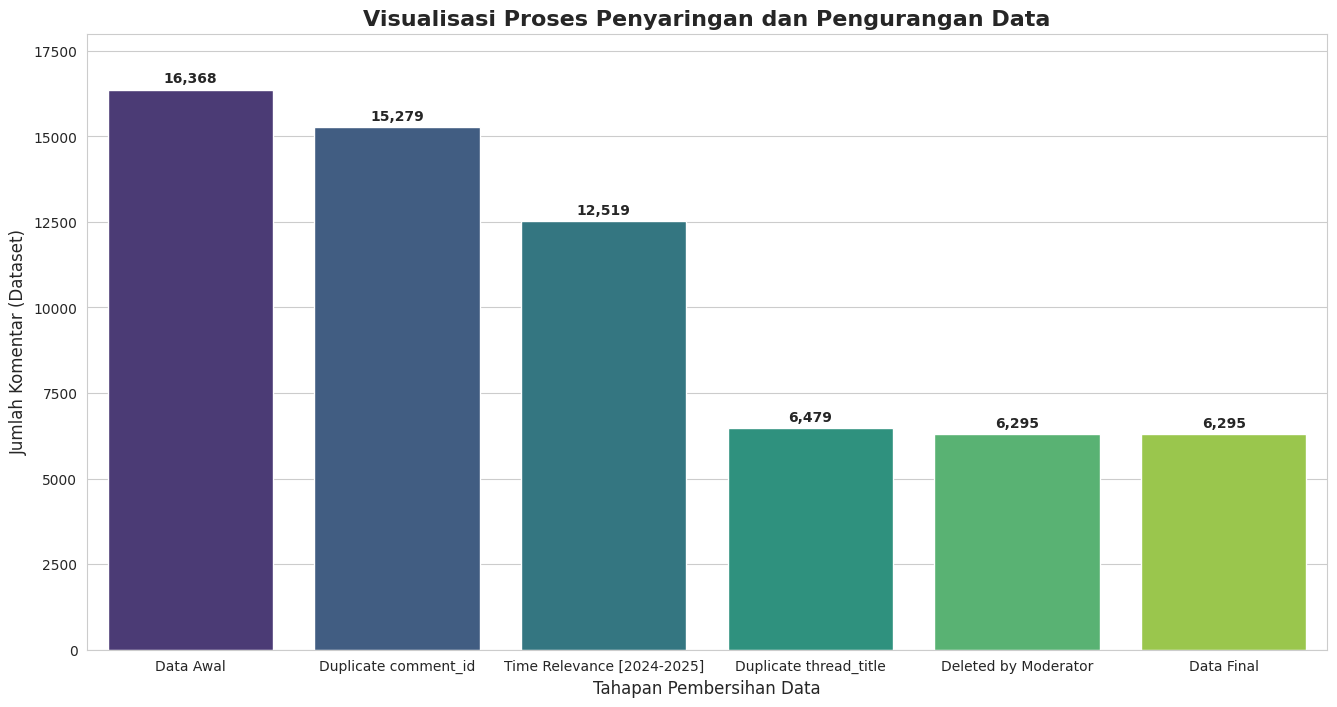

In [19]:
# ==============================================================================
# SEL 7: VISUALISASI PROSES PENYARINGAN DATA
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data yang Anda berikan
tahapan = [
    'Data Awal',
    'Duplicate comment_id',
    'Time Relevance [2024-2025]',
    'Duplicate thread_title',
    'Deleted by Moderator',
    'Data Final'
]
jumlah_data = [16368, 15279, 12519, 6479, 6295, 6295]

# Membuat DataFrame untuk plotting
df_visual = pd.DataFrame({
    'Tahapan': tahapan,
    'Jumlah Data': jumlah_data
})

# Mengatur style plot agar lebih menarik
sns.set_style("whitegrid")
plt.figure(figsize=(16, 8))

# Membuat bar plot
bar_plot = sns.barplot(
    x='Tahapan',
    y='Jumlah Data',
    data=df_visual,
    palette='viridis' # Skema warna
)

# Menambahkan label angka di atas setiap batang
for index, row in df_visual.iterrows():
    bar_plot.text(
        x=index,
        y=row['Jumlah Data'] + 200, # Atur posisi teks sedikit di atas batang
        s=f"{row['Jumlah Data']:,}", # Format angka dengan pemisah ribuan
        ha='center', # Horizontal alignment
        fontweight='bold'
    )

# Memberi judul dan label
plt.title('Visualisasi Proses Penyaringan dan Pengurangan Data', fontsize=16, fontweight='bold')
plt.ylabel('Jumlah Komentar (Dataset)', fontsize=12)
plt.xlabel('Tahapan Pembersihan Data', fontsize=12)
plt.ylim(0, max(jumlah_data) * 1.1) # Atur batas atas sumbu y agar ada ruang untuk teks

# Menyimpan gambar
nama_file_gambar = "visualisasi_penyaringan_data.png"
plt.savefig(nama_file_gambar)

print(f"✅ Visualisasi grafik telah dibuat dan disimpan sebagai '{nama_file_gambar}'")